In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_data = pd.read_csv('data/ab_data.zip')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [6]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.

In [7]:
daily_data['conversion'] = 100 * daily_data['converted'] / daily_data['users_count']
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


In [24]:
mask = (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
round(daily_data[mask]['conversion'],2)

6    12.32
Name: conversion, dtype: float64

## ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

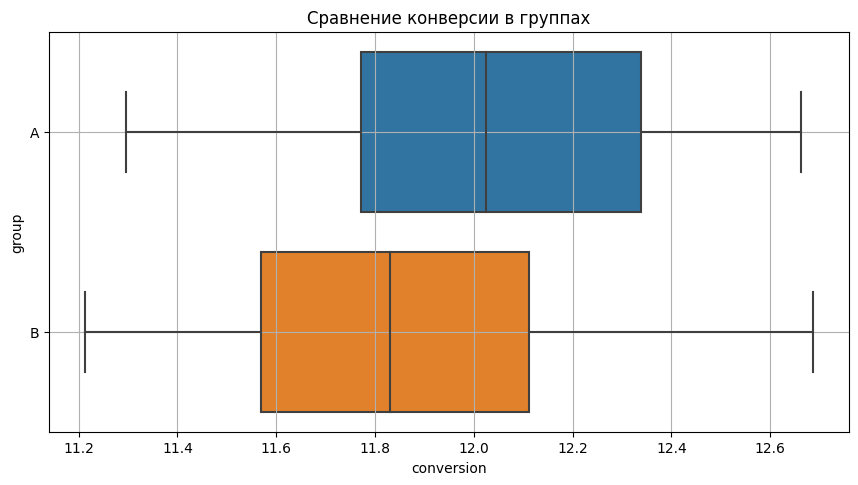

In [25]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True);

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [26]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат. 

Кумулятивный график конверсии может выглядеть, например, так: 

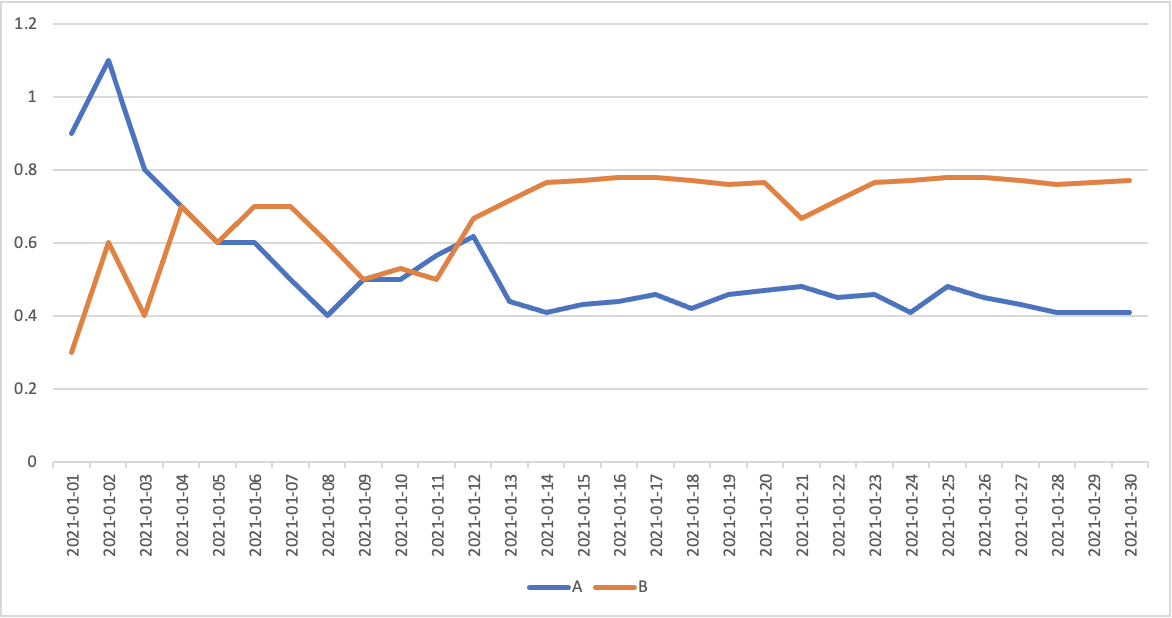

# Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется!

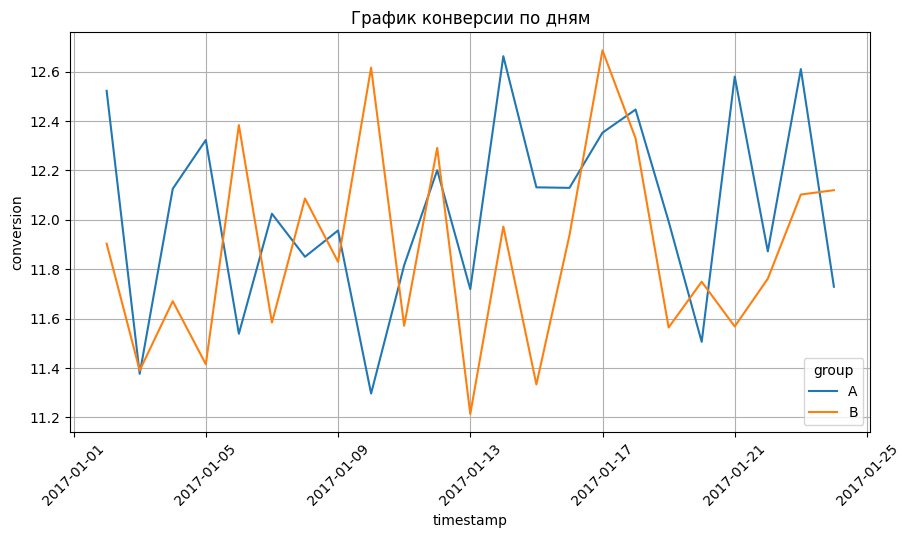

In [27]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [28]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\trigubov\AppData\Local\Temp\ipykernel_13712\906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

# вычисляем кумулятивную сумму количества посетителей

In [30]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count
0,2017-01-02,A,2851,357,12.521922,2851
1,2017-01-02,B,2848,339,11.903090,2848
2,2017-01-03,A,6584,749,11.376063,9435
3,2017-01-03,B,6620,754,11.389728,9468
4,2017-01-04,A,6573,797,12.125361,16008


In [31]:
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


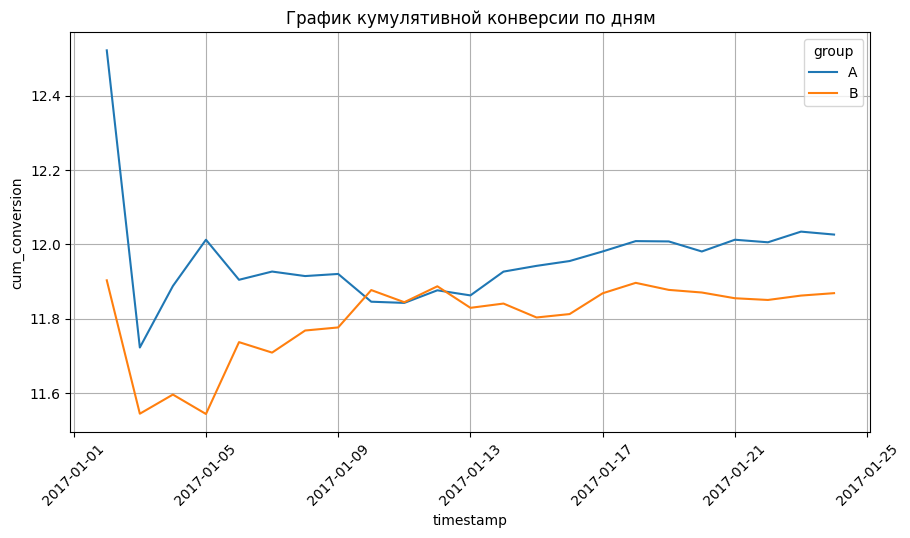

In [32]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Вернёмся к нашей задаче об оценке разницы конверсий действия «Добавить товар в корзину» для двух вариантов рекомендательных систем.

Сначала подготовим данные к проведению статистических тестов. Для этого нам нужно рассчитать количество пользователей, совершивших конверсию, и общее количество пользователей в каждой контрольной и тестовой группах.

Cгруппируем таблицу ab_data по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы:

In [33]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


In [34]:
from statsmodels.stats.proportion import proportions_ztest

Для получения p-value необходимо передать в функцию следующие аргументы:

count — количество «успехов» (в каждой из групп). В данном случае это количество пользователей, которые совершили целевое действие в каждой группе.
nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
alternative — вид альтернативной гипотезы ('two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя). По умолчанию параметр равен 'two-sided'.
value — число, с которым сравнивается разница между двумя пропорциями. По умолчанию равно 0.

Примечание. Этот параметр может пригодиться, если необходимо проверить разницу между пропорциями на соответствие конкретному числу: например, гипотезы вида «Конверсия в группе A меньше, чем конверсия в группе B на 3 %». Тогда в качестве значения value можно установить число 0.03.

Зададим уровень значимости  и будем сравнивать полученное p-value с ним.

Примечание. Давайте вспомним, что:

Если полученное значение p-value ниже уровня значимости (), это означает, что результаты статистически значимы и согласуются с альтернативной гипотезой.
Если полученное значение p-value выше уровня значимости (), результаты считаются статистически незначимыми и нельзя отвергнуть нулевую гипотезу.

In [35]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.19
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


Итак, мы получили p-value = 0.19. Это больше, чем заданный уровень значимости 0.05, а значит, мы должны принять нулевую гипотезу о равенстве конверсий.

А что, если мы хотим уточнить исследование и проверить гипотезу о том, что варианты А и B не просто идентичны между собой, а вариант А даже лучше варианта B по метрике конверсии? Тогда нам нужно переформулировать гипотезы таким образом, чтобы альтернативная гипотеза отражала наш бизнес-вопрос:

Нулевая (будет задавать отсутствие эффекта): конверсия в группе А меньше либо равна конверсии в группе B.

Альтернативная (будет задавать наличие эффекта): конверсия в группе А больше, чем конверсия в группе B.



In [36]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.095
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.095
У нас нет оснований отвергнуть нулевую гипотезу


Итак, p-value = 0.095 вновь больше, чем уровень значимости 0.05. А значит, что статистика говорит нам о том, что вариант A все таки не лучше, чем вариант B, что, в принципе, было ожидаемым из предыдущего тестирования о равенстве конверсий.

# X 2  -ТЕСТ ДЛЯ ПРОПОРЦИЙ

In [37]:
from statsmodels.stats.proportion import proportions_chisquare

Для получения -статистики и p-value необходимо передать в функцию следующие аргументы:

count — количество «успехов» (в каждой из групп). В данном случае это количество пользователей, которые совершили целевое действие в каждой группе.
nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
value — число, с которым сравнивается разница между двумя пропорциями. По умолчанию равно 0.

In [38]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.19
# У нас нет оснований отвергнуть нулевую гипотезу

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


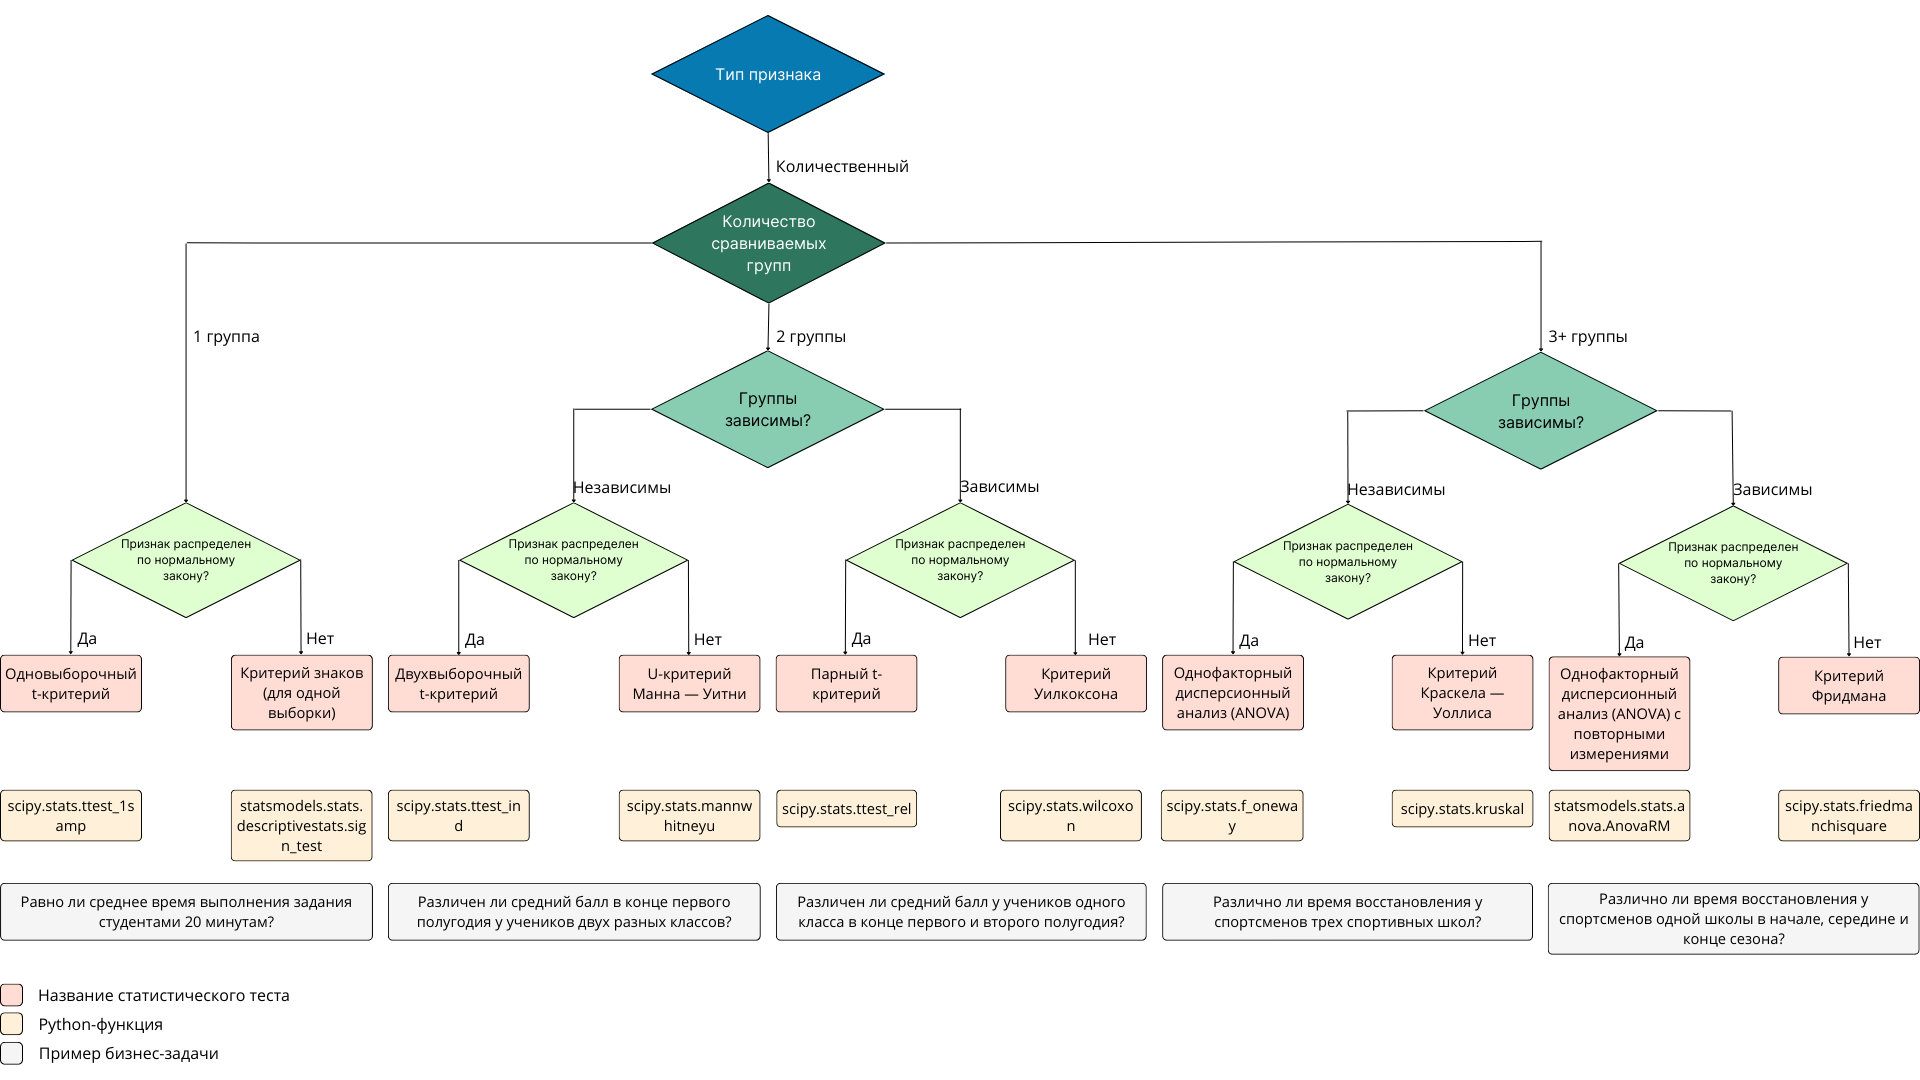